## 03 Which non-fossil fuel energy technology will have the best price in the future?

In this analysis the cost metric used is the levelized cost of electricity (LCOE) rather than observed market electricity prices. LCOE represents the average lifetime cost per unit of electricity generated by a given technology, incorporating investment, operation and maintenance, fuel (where applicable), and decommissioning costs, discounted over the project’s economic life. 

It is therefore a technology‑specific cost indicator that enables a like‑for‑like comparison between different non‑fossil options such as solar PV, wind, hydro, and bioenergy, independent of country‑specific tariffs, taxes, subsidies, or market design. The forecast results should thus be interpreted as projections of future cost per MWh by technology (LCOE), not as predictions of future retail or wholesale electricity prices faced by consumers or observed on power markets.

In [1]:
import pandas as pd

url = "https://ourworldindata.org/grapher/levelized-cost-of-energy.csv"
df = pd.read_csv(url)

# Focus on World data
df_world = df[df["Entity"] == "World"].copy()

lcoe_cols = [
    "Bioenergy levelized cost of energy",
    "Geothermal levelized cost of energy",
    "Offshore wind levelized cost of energy",
    "Solar photovoltaic levelized cost of energy",
    "Concentrated solar power levelized cost of energy",
    "Hydropower levelized cost of energy",
    "Onshore wind levelized cost of energy",
]

df_world = df_world[["Year"] + lcoe_cols]

# Sort the data by Year
df_world = df_world.sort_values(by="Year").reset_index(drop=True)

# ffil missing values   
df_world[lcoe_cols] = df_world[lcoe_cols].ffill()

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Forecasts LCOE for specified technologies using a log-linear (learning curve) regression
# on the most recent historical data and clamps the prediction to a minimum value.

def forecast_lcoe_log_linear(df_world, lcoe_cols, future_year=2040, recent_years=10, min_fraction=0.1):

    df_forecast = df_world.copy()

    # Ensure all prediction years exist in the DataFrame
    last_historical_year = df_forecast["Year"].max()
    new_years = [year for year in range(last_historical_year + 1, future_year + 1)
                 if year not in df_forecast["Year"].values]
    
    if new_years:
        # Create new rows efficiently for the missing years
        new_rows = pd.DataFrame({'Year': new_years})
        df_forecast = pd.concat([df_forecast, new_rows], ignore_index=True)
        df_forecast = df_forecast.sort_values(by="Year").reset_index(drop=True)

    prediction_years = df_forecast[df_forecast["Year"] > last_historical_year]["Year"].values

    # Iterate through each LCOE column and perform forecasting
    for col in lcoe_cols:
        data = df_forecast[["Year", col]].dropna(subset=[col])
        
        # Check for sufficient data after dropping NaNs
        if len(data) < recent_years:
            print(f"Skipping {col}: Insufficient data points ({len(data)} < {recent_years}).")
            continue

        last_actual = data[col].iloc[-1]
        min_value = last_actual * min_fraction

        # Use only the most recent years for regression
        data_recent = data.tail(recent_years)
        X_fit = data_recent[["Year"]].values
        y_fit = data_recent[col].values
        
        
        mask = y_fit > 0
        X_fit = X_fit[mask]
        y_log = np.log(y_fit[mask])

        model = LinearRegression()
        model.fit(X_fit, y_log)


        X_pred = prediction_years.reshape(-1, 1)
        y_pred_log = model.predict(X_pred)
        y_pred = np.exp(y_pred_log)
        y_pred_clamped = np.maximum(y_pred, min_value)
        df_forecast.loc[df_forecast["Year"].isin(prediction_years), col] = y_pred_clamped

    return df_forecast

df_world_prediction = forecast_lcoe_log_linear(df_world, lcoe_cols)


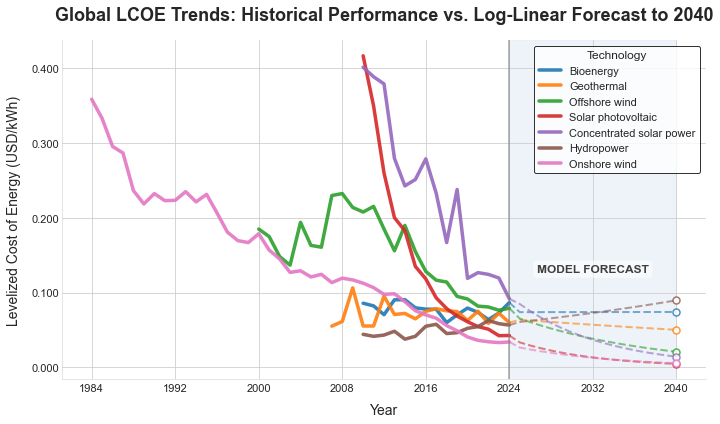

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.style.use('seaborn-v0_8-whitegrid')

PREDICTION_START_YEAR = 2024
FUTURE_YEAR = 2040

fig, ax = plt.subplots(figsize=(10, 6)) 

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_facecolor("white") # Explicitly set background to white if the style allows a tint

for idx, col in enumerate(lcoe_cols):
    data = df_world_prediction[["Year", col]].dropna(subset=[col])
    if data.empty:
        continue
        
    actual = data[data["Year"] <= PREDICTION_START_YEAR]
    predicted = data[data["Year"] >= PREDICTION_START_YEAR] # Start prediction line slightly before 2024 to connect
    label = col.replace(" levelized cost of energy", "")

    # Plot actual (Historical) data
    ax.plot(
        actual["Year"],
        actual[col],
        label=label,
        linewidth=3.5,
        color=colors[idx % len(colors)],
        alpha=0.9,
    )
    
    # predictoted Data
    if not predicted.empty:
        
        ax.plot(
            predicted["Year"],
            predicted[col],
            linewidth=2,
            color=colors[idx % len(colors)],
            linestyle='--',
            alpha=0.6, 
            label='_nolegend_'
        )
        # big O at the end of the prediction line
        ax.plot(
            predicted["Year"].iloc[-1],
            predicted[col].iloc[-1],
            marker='o',
            markersize=7,
            color=colors[idx % len(colors)],
            alpha=0.8,
            markeredgewidth=1.5,
            markerfacecolor='white',
            label='_nolegend_'
        )


# Vertical Line at the point of transition
ax.axvline(
    x=PREDICTION_START_YEAR, 
    color='gray', 
    linestyle='-', 
    linewidth=1.5,
    alpha=0.7
)

# Shaded Area for the Forecast Period
ax.axvspan(
    PREDICTION_START_YEAR, FUTURE_YEAR, 
    color='#dce9f5', # A light blue/grey for shading
    alpha=0.5, 
    zorder=0
)

# Annotation for the forecast area
ax.text(
    (PREDICTION_START_YEAR + FUTURE_YEAR) / 2, # Center the text in the shaded area
    ax.get_ylim()[1] * 0.30,
    "MODEL FORECAST",
    fontsize=12,
    color="#404040",
    ha='center',
    va='center',
    fontweight='bold',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
)


ax.set_xlabel("Year", fontsize=14, labelpad=10)
ax.set_ylabel("Levelized Cost of Energy (USD/kWh)", fontsize=14, labelpad=10)
ax.set_title(
    "Global LCOE Trends: Historical Performance vs. Log-Linear Forecast to 2040",
    fontsize=18,
    fontweight='bold',
    pad=20 # Add padding to separate title from plot area
)


formatter = mticker.FuncFormatter(lambda x, p: f'{x:.3f}')
ax.yaxis.set_major_formatter(formatter)

ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Tidy legend
ax.legend(title="Technology", fontsize=11, title_fontsize=12, loc='upper right', frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()